In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
# importing sklearn models and metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, cohen_kappa_score, f1_score, classification_report, balanced_accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler


# Supervised Machine Learning


This section will give a brief overview of a couple of supervised machine learning methods.

(You'll want to look at the slides for additional information on how to approach these questions.)

<h2 style="color:red;font-weight:bold">Question 1 </h2>

<span style="color:red;font-weight:bold">Train two models using data from the 2020 election to predict Democratic party vote share. Evaluate your results using the 2024 election results. Assess the results using the `mean_squared_error` and `r2_score`</span>

In [8]:
election_data = pd.read_csv("election_data.csv")


<h2 style="color:red;font-weight:bold"> Question 2 </h2>

<span style='color:red;font-weight:bold'>Create two models to predict whether a country experienced a terrorist attack in 2020. Evaluate your results on a random sample of held-out data. Examine the confusion matrix, and use `cohens_kappa_score`, `balanced_accuracy_score` to compare your results.</span>

In [9]:
gtd = pd.read_csv("gtd_data.csv")


# Extra code

### Using a pipeline

Pipelines are a way to ensure consistent pre-processing on the training and testing data. You can write a pipeline by using the `Pipeline` function and passing a list of tuples with a set of processing steps and a final estimator.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

gtd = pd.read_csv("gtd_data.csv")
gtd_dummified = pd.get_dummies(gtd, columns=['any_attacks','any_attacks_prior_year', 'autonomy'],  
                            drop_first=True, dtype='int')
gtd_features = gtd_dummified[['gdp_pcap', 'oil', 'liberal_democracy','political_stability', 'population']]
gtd_outcome = gtd_dummified['any_attacks_yes']

train_X, test_X, train_y, test_y = train_test_split(gtd_features,
                                                    gtd_outcome,
                                                    test_size=0.30,
                                                    random_state=20)

C:\Users\neilb\AppData\Local\Temp\ipykernel_32720\1811181307.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


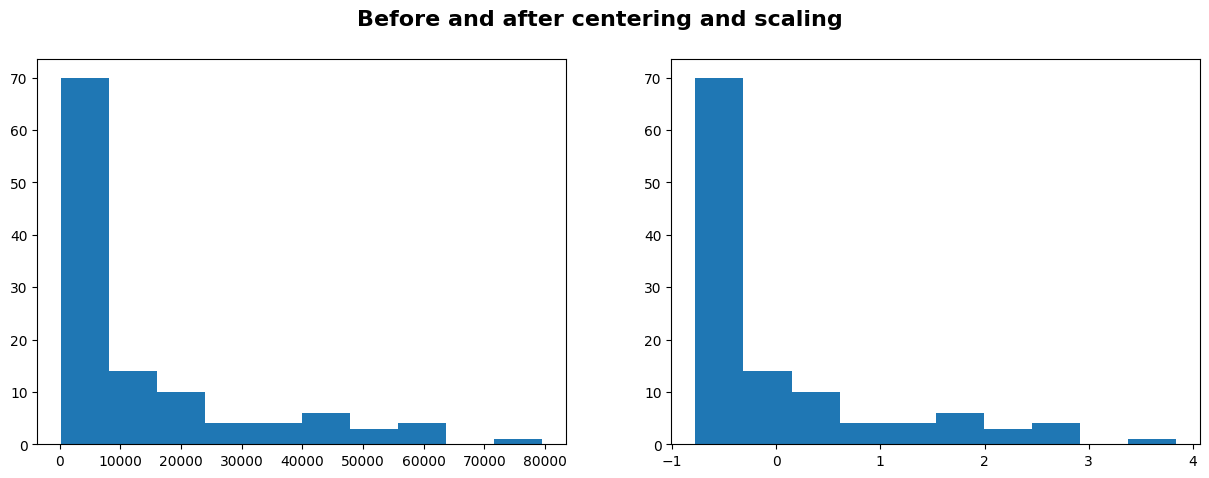

In [11]:



# Scaling predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X)
X_test_scaled = scaler.transform(test_X)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(train_X.iloc[:,0])
axes[1].hist(X_train_scaled[:,0])
fig.suptitle('Before and after centering and scaling', fontsize=16, fontweight='bold')
fig.show()






For instance, here's a pipeline for a model that standardizes the features and applies [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) before using a logistic regression model to predict some outcome:

In [12]:
logit_pipe = Pipeline(
    steps  = [
        ('scale', StandardScaler()),
        ('pca', PCA()),
        ('logit_model', LogisticRegression())
         ]
    )


Now calling `fit` will apply the pre-processing steps and run the regression model:

In [13]:
logit_pipe.fit(train_X, train_y)


,steps,"[('scale', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'


And then calling `predict` will automatically apply those same pre-processing steps to new input data:

In [14]:
y_preds = logit_pipe.predict(test_X)


Now we'll check out the performance:

In [15]:
balanced_accuracy_score(y_preds, test_y)

0.7539184952978057

Where this really becomes useful is in cases where we have a complicated set of transformations that need to be applied to the data. For instance, I've got a mixture of categorical and numeric variables that require different kinds of processing steps before I use them in a model. I can make a single pipeline that applies the appropriate methods to each input and spits out a prediction all in one step:

In [17]:
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
positive_numeric_prep = Pipeline(
    steps=[
        ("power_transform", PowerTransformer(method='box-cox'))
    ]
)
categorical_prep= Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop='first'))
    ]
)
numeric_prep = Pipeline(
    steps=[
         ("transform", PowerTransformer(method='yeo-johnson'))
    ]
)
preprocessor = ColumnTransformer(
    [
        ("categorical features", categorical_prep, ["autonomy", 'any_attacks_prior_year']),
        ("numeric features >0", positive_numeric_prep, ["gdp_pcap",  "population", "life_expectancy"]),
        ("all other numeric features", numeric_prep, ["liberal_democracy", "political_stability","resource_rents", "oil"]),
    ]
)
logit_pipe = make_pipeline(preprocessor,
                           LogisticRegression(C = 3))

logit_pipe


,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical features', ...), ('numeric features >0', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [18]:
X = gtd[[ 'autonomy', 'gdp_pcap', 'population', 'liberal_democracy','political_stability', "resource_rents", "oil", "life_expectancy", 'any_attacks_prior_year']] # list of inputs
y = pd.get_dummies(gtd['any_attacks'], drop_first=True, dtype='int').iloc[:, 0]                                                                                   # making a 1/0 encoded version of the terrorist attacks variable
train_X, test_X, train_y, test_y = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=20)


Fit the model with the training data:


In [19]:
logit_pipe.fit(train_X, train_y)

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical features', ...), ('numeric features >0', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


We can still use the `.predict` method with the fitted pipeline to get a prediction for new data, the difference is that the pre-processing steps are automatically applied to the new data:

In [20]:
y_preds = logit_pipe.predict(test_X)
balanced_accuracy_score(y_preds, test_y)

0.823076923076923

## Cross-validation methods

In the previous examples we used a single training/testing split to train and evaluate a model. But how do we know that our model performance isn't just a matter of luck? We can improve our understanding of model performance further by using a method called K-fold cross-validation. We'll split the data into "K" folds, use K-1 folds for training, and then the remaining fold for testing, then we'll repeat "K" times and average our measure of model performance over each iteration. This lowers the chances that our results are attributable to a lucky random split.

Here's an example of performing K-fold cross validation using the logit pipeline we created in the previous step:

In [21]:
from sklearn.model_selection import cross_validate, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=199)
scores = cross_validate(logit_pipe, X, y, cv=kf,
                        scoring=('accuracy',
                                 'balanced_accuracy', 
                                 'precision', 
                                 'recall'),
                        return_train_score=True)



c:\Users\neilb\Documents\UMD\BSOS326\BSOS326Fall2025\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [29]:
pd.DataFrame(scores).describe()

,fit_time,score_time,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,test_precision,train_precision,test_recall,train_recall
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.052336,0.009820,0.816912,0.840340,0.816365,0.837817,0.843001,0.828294,0.787302,0.813382
std,0.006837,0.005472,0.133537,0.011408,0.133816,0.011402,0.181484,0.014286,0.151770,0.017895
min,0.045073,0.007354,0.588235,0.827815,0.590278,0.825380,0.555556,0.808824,0.571429,0.787879
25%,0.046475,0.007573,0.735294,0.833609,0.732887,0.831300,0.678571,0.818860,0.666667,0.800032
50%,0.052069,0.008097,0.823529,0.840000,0.829545,0.837662,0.928571,0.823491,0.805556,0.813503
75%,0.053813,0.008481,0.923713,0.845000,0.918651,0.840018,1.000000,0.833333,0.870536,0.820217
max,0.064894,0.025230,1.000000,0.866667,1.000000,0.865132,1.000000,0.852459,1.000000,0.850746
